In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [6]:
def func(x, a, b):
    #function used for fitting dzdr/dz - alpha slope
    return a/x + b


def estimate_slope_nws(data_dict, dataset_name, zdrpct_bin_width, dbz_bin_width, dbz_bin_spacing):
    
    #extra arrays from dict
    dbz_array = data_dict['dbz_array']
    zdr_array = data_dict['zdr_db_array']
    kdp_array = data_dict['kdp_array']
    att_array = data_dict['att_array']
    
    #dzdr/dz slope calculation limits
    slope_z_min = 20
    slope_z_max = 40
    
    #set reflectivity bins
    min_dbz = 20
    max_dbz = 50
    dbz_bin_centres = np.arange(min_dbz, max_dbz+1, dbz_bin_spacing)
    #print(dbz_bin_centres)
    #set percentile bins
    zdrpct_bin = np.arange(zdrpct_bin_width, 100, zdrpct_bin_width)
    zdrpct_edges = np.append(np.append([0], zdrpct_bin), [100])
    n_zdrpct_bins  = len(zdrpct_bin) + 1
    n_zdrpct_edges = len(zdrpct_edges)
    #allocate zdr array
    zdrpct_median_array = np.zeros((len(dbz_bin_centres), n_zdrpct_bins))
    zdrpct_attsum_array = np.zeros((len(dbz_bin_centres), n_zdrpct_bins))
    zdrpct_kdpsum_array = np.zeros((len(dbz_bin_centres), n_zdrpct_bins))
    #zdrpct_edge_array   = np.zeros((len(dbz_bin_centres), n_zdrpct_edges))
    
    #core analysis
    for i, dbz_centre in enumerate(dbz_bin_centres):
        #extract subset for dbz bin
        dbz_bin_lower = dbz_centre - dbz_bin_width/2
        dbz_bin_upper = dbz_centre + dbz_bin_width/2
        #create dbz subset mask
        dbz_subset_mask = np.logical_and(dbz_array >= dbz_bin_lower, dbz_array < dbz_bin_upper)
        #subset
        zdr_subset = zdr_array[dbz_subset_mask]
        att_subset = att_array[dbz_subset_mask]
        kdp_subset = kdp_array[dbz_subset_mask]
        #calculate percentiles
        zdr_subset_min = np.min(zdr_subset)
        zdr_subset_max = np.max(zdr_subset)
        zdr_bin_edges = np.percentile(zdr_subset, zdrpct_bin)
        zdr_bin_edges = np.append(np.append([zdr_subset_min], zdr_bin_edges), [zdr_subset_max])
        #allocate zdr percentile values to array for plotting later
        #zdrpct_edge_array[i,:] = zdr_bin_edges
        #calculate median between each percentile value and store for plotting.
        #also calculate the sums of att and kdp within each percentile for the Z bin
        for j in range(0, n_zdrpct_bins):
            zdr_subset_mask = np.logical_and(zdr_subset>=zdr_bin_edges[j], zdr_subset<zdr_bin_edges[j+1])
            zdrpct_median_array[i,j] = np.median(zdr_subset[zdr_subset_mask])
            zdrpct_attsum_array[i,j] = np.nansum(att_subset[zdr_subset_mask])
            zdrpct_kdpsum_array[i,j] = np.nansum(kdp_subset[zdr_subset_mask])
    
    #calculate dZDR/dZ for zdrpct
    alpha_array = np.zeros(n_zdrpct_bins)
    slope_array = np.zeros(n_zdrpct_bins)

    for i in range(0, n_zdrpct_bins):
        #find matching samples
        slope_idx = np.where(np.logical_and(dbz_bin_centres>=slope_z_min, dbz_bin_centres<=slope_z_max))[0]
        #calculate alpha for dbz bin
        alpha_array[i] = np.sum(zdrpct_attsum_array[slope_idx,i])/np.sum(zdrpct_kdpsum_array[slope_idx,i])
        #calculate dzdr/dz for dbz bin
        upper_zdr = np.nan
        upper_idx = -1
        while np.isnan(upper_zdr):
            upper_zdr = zdrpct_median_array[slope_idx[upper_idx],i]
            upper_idx = upper_idx - 1
            new_slope_z_max = dbz_bin_centres[upper_idx]
            #print(new_slope_z_max)
        lower_zdr = zdrpct_median_array[slope_idx[0],i]
        slope_array[i] = (upper_zdr - lower_zdr)/(new_slope_z_max-slope_z_min)
    
    return [slope_array, alpha_array]

def plt_estimator(data, marker_style, line_style, color, legend_name):
    
    #unpack data
    slope_data = data[0]
    alpha_data = data[1]

    #nonlinear fitting for alpha-zdr/z slope
    def func(x, a, b, c):
        return a * np.exp(-b * x) - c

    #plotting
    plt.plot(slope_data, alpha_data, color = color, marker=marker_style, lw=0,
            label = legend_name)

def fit_custom(dsd_list):
    
    cutoff_x = 0.045
    slope_data = []
    alpha_data = []
    #extract all dsd datasets
    for item in dsd_list:
        slope_data = np.append(slope_data, item[0])
        alpha_data = np.append(alpha_data, item[1])
    #fit to curve
    popt, pcov = curve_fit(func, slope_data, alpha_data)
    #plot
    plot_x = np.linspace(0,0.1,100)
    plot_y = func(plot_x, *popt)
    cutoff_y = func(cutoff_x, *popt)
    plot_y[plot_x>cutoff_x] = cutoff_y
    plt.plot(plot_x, plot_y, 'r-', label='fit: a=%1.6f, b=%1.6f' % tuple(popt))
    
def fit_estimator_bilinear(dsd_list):
    
    cutoff = 0.04
    slope_data = []
    alpha_data = []
    #extract all dsd datasets
    for item in dsd_list:
        slope_data = np.append(slope_data, item[0])
        alpha_data = np.append(alpha_data, item[1])
    
    #fit linear model below cutoff
    myfit_part1   = np.polyfit(slope_data[slope_data<cutoff], alpha_data[slope_data<cutoff], 1)
    mymodel_part1 = np.poly1d(myfit_part1)
    #fit y intercept above cutoff
    myfit_part2   = np.polyfit(slope_data[slope_data>=cutoff], alpha_data[slope_data>=cutoff], 0)
    mymodel_part2 = np.poly1d(myfit_part2)
    
    #find intercept of model 1 and model 2
    m1 = myfit_part1[0]
    c1 = myfit_part1[1]
    m2 = 0
    c2 = myfit_part2[0]
    model_change_x = (c1-c2) / (m2-m1)
    model_change_y = m1 * model_change_x + c1
    
    #plotting
    plot_x = np.linspace(0,0.2,100)
    plot_y = np.zeros_like(plot_x) + model_change_y
    plot_y[plot_x<model_change_x] = mymodel_part1(plot_x[plot_x<model_change_x])
    plt.plot(plot_x, plot_y, 'b', label='bilinear')
    print('linear model', mymodel_part1, 'change x', cutoff, 'constant model y', model_change_y)
    
    return myfit_part1, myfit_part2
    


def worker(band, temp, cant):
    
    load_data = np.load(f'pytmatrix_out/brisbane_radarsim_{band}_{cant}deg_{temp}C.npz', allow_pickle=True)
    bris_dict = {'dbz_array':load_data['dbz_array'], 'zdr_db_array':load_data['zdr_db_array'],
                 'kdp_array':load_data['kdp_array'], 'att_array':load_data['att_array'], 'time_array':load_data['att_array'], 'rain_array':load_data['rain_array']}
    print(np.sum(bris_dict['dbz_array']>10))
    load_data = np.load(f'pytmatrix_out/darwin_radarsim_{band}_{cant}deg_{temp}C.npz')
    darw_dict = {'dbz_array':load_data['dbz_array'], 'zdr_db_array':load_data['zdr_db_array'],
                 'kdp_array':load_data['kdp_array'], 'att_array':load_data['att_array'], 'time_array':load_data['att_array'], 'rain_array':load_data['rain_array']}
    print(np.sum(darw_dict['dbz_array']>10))
    load_data = np.load(f'pytmatrix_out/broadmeadows_jaya_{band}_{cant}deg_{temp}C.npz')
    broad_dict = {'dbz_array':load_data['dbz_array'], 'zdr_db_array':load_data['zdr_db_array'],
                 'kdp_array':load_data['kdp_array'], 'att_array':load_data['att_array'], 'rain_array':load_data['rain_array']}
    print(np.sum(broad_dict['dbz_array']>10))
    load_data = np.load(f'pytmatrix_out/mtview_jaya_{band}_{cant}deg_{temp}C.npz')
    mtview_dict = {'dbz_array':load_data['dbz_array'], 'zdr_db_array':load_data['zdr_db_array'],
                 'kdp_array':load_data['kdp_array'], 'att_array':load_data['att_array'], 'rain_array':load_data['rain_array']}
    print(np.sum(mtview_dict['dbz_array']>10))
    mtview_estimate = estimate_slope_nws(mtview_dict, 'MtView',20, 5, 5)
    broad_estimate = estimate_slope_nws(broad_dict, 'Broadmeadows',20, 5, 5)
    darw_estimate = estimate_slope_nws(darw_dict, 'Darwin',20, 5, 5)
    bris_estimate = estimate_slope_nws(bris_dict, 'Brisbane',20, 5, 5)
    
    plt_estimator(mtview_estimate, 'o','-', 'r', 'MtView')
    plt_estimator(broad_estimate, '^', '--', 'b', 'Broadmeadows')
    plt_estimator(darw_estimate, '*', ':', 'm', 'Darwin')
    plt_estimator(bris_estimate, 's', '-.', 'g', 'Brisbane')

    fit_custom([mtview_estimate, broad_estimate, darw_estimate, bris_estimate])
    
#    myfit_part1, myfit_part2 = fit_estimator_bilinear([mtview_estimate, broad_estimate, darw_estimate, bris_estimate])
    
    plt.title(f'{band} band at {temp}C')
    plt.xlabel("$\Delta Z_{DR}/\Delta Z$ ")
    plt.ylabel(r"$ \alpha (dB deg^{-1})$")
    plt.grid()
    plt.legend()
    plt.xlim([0, 0.06])
    plt.ylim([0, 0.2])
    
    #save
#    np.savez(f'alpha_fits/alphafit_{band}_{cant}deg_{temp}C.npz', myfit_part1=myfit_part1, myfit_part2=myfit_part2)

329
11146
39279
74850
330
11146
39263
74818
330
11144
39242
74779


<ipython-input-6-4db32a85b68a>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a/x + b
<ipython-input-6-4db32a85b68a>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a/x + b
<ipython-input-6-4db32a85b68a>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a/x + b


329
11126
39320
74943
329
11121
39306
74916
329
11117
39293
74881


<ipython-input-6-4db32a85b68a>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a/x + b
<ipython-input-6-4db32a85b68a>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a/x + b
<ipython-input-6-4db32a85b68a>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a/x + b


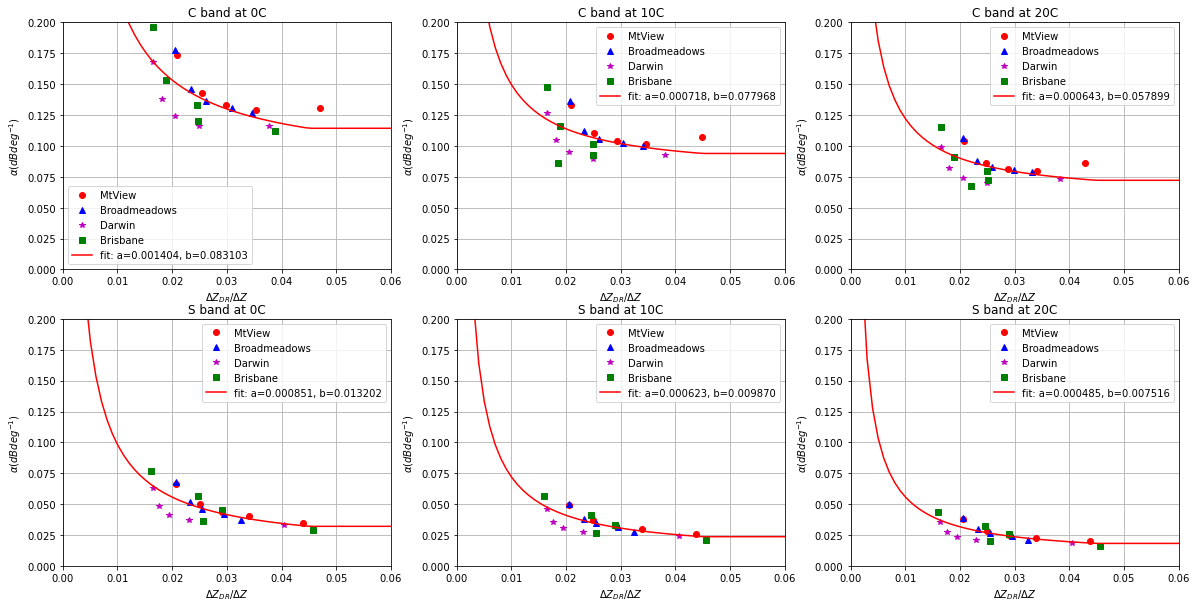

In [7]:
plt.figure(figsize=(20,10))

ax = plt.subplot(231)
worker('C', 0, 10)
ax = plt.subplot(232)
worker('C', 10, 10)
ax = plt.subplot(233)
worker('C', 20, 10)

ax = plt.subplot(234)
worker('S', 0, 10)
ax = plt.subplot(235)
worker('S', 10, 10)
ax = plt.subplot(236)
worker('S', 20, 10)


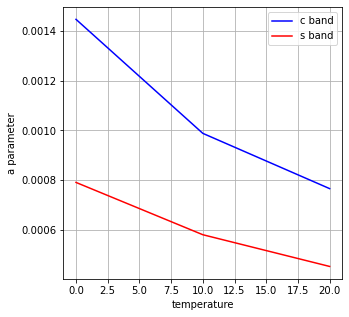

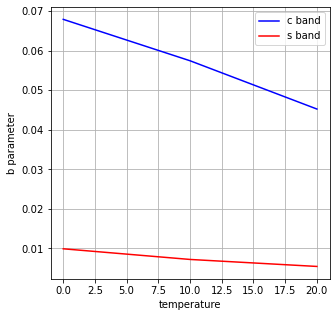

In [60]:
temperature = [0,10,20]
c_band_a = [0.001448, 0.000988, 0.000765]
c_band_b = [0.06791, 0.05744, 0.04524]
s_band_a = [0.000790, 0.000579, 0.000451]
s_band_b = [0.00991, 0.007217, 0.005449]

plt.figure(figsize=(5,5))
plt.plot(temperature, c_band_a, 'b', label='c band')
plt.plot(temperature, s_band_a, 'r', label='s band')
plt.xlabel('temperature')
plt.ylabel('a parameter')
plt.legend()
plt.grid()

plt.figure(figsize=(5,5))
plt.plot(temperature, c_band_b, 'b', label='c band')
plt.plot(temperature, s_band_b, 'r', label='s band')
plt.xlabel('temperature')
plt.ylabel('b parameter')
plt.legend()
plt.grid()

In [101]:
def alpha_function_from_temperature(band, tempin):
    
    #define temperature for each set of coefficents
    temp_list = np.array([0,10,20])
    #find index for upper and lower bounds
    if tempin <= temp_list[0]:
        lower_idx = 0
        upper_idx = 1
    elif tempin >= temp_list[-1]:
        lower_idx = np.size(temp_list)-2
        upper_idx = np.size(temp_list)-1
    else:
        lower_idx = np.where(temp_list<tempin)[0][-1]
        upper_idx = np.where(temp_list>=tempin)[0][0]
    #define function coefficents
    if band == 'C':
        func_a = [0.001448, 0.000988, 0.000765]
        func_b = [0.06791, 0.05744, 0.04524]
        max_alpha = 0.2
    elif band == 'S':    
        func_a = [0.000790, 0.000579, 0.000451]
        func_b = [0.00991, 0.007217, 0.005449]
        max_alpha = 0.1
    else:
        print('band unknown')
        return None
    #find linear regression a
    m_a = (func_a[upper_idx]-func_a[lower_idx])/(temp_list[upper_idx]-temp_list[lower_idx])
    c_a = func_a[upper_idx]-m_a*temp_list[upper_idx]
    fit_a = tempin*m_a + c_a
    #find linear regression a
    m_b = (func_b[upper_idx]-func_b[lower_idx])/(temp_list[upper_idx]-temp_list[lower_idx])
    c_b = func_b[upper_idx]-m_b*temp_list[upper_idx]
    fit_b = tempin*m_b + c_b        
    
    return fit_a, fit_b
    
    

In [102]:
fit_a, fit_b = alpha_function_from_temperature('C', 10.001)

print(fit_a, fit_b)

0.0009879777 0.057438779999999995


nan


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
